# Workshop CentraleSupélec - CeSIA

- Création : 02/2025 par [Nicolas Guillard](mailto:nicolas.guillar@securite-ia.fr) - bénévole au [CeSIA](https://www.securite-ia.fr/).

Créer en s'inspirant particulièrement de [Générer des noms de villes et communes françaises](https://github.com/alxndrTL/villes) par [Alexandre TL](https://www.youtube.com/@alexandretl)


## Présentation du sujet et Plan

## Indications de travail

## Les modules et paramétrages globaux

Tous les modules nécessaires sont importés. A moins d'un besoin spécifique, il n'y aura pas besoin de modifier le bloc de code suivant.

In [ ]:
import pandas as pd

import math
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm

import datetime

from utils import print_colore
import numpy as np
import random

### Device

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### Paramétrages

In [3]:
# Retirer la limite du nombre maximal de lignes affichées dans un tableau pandas
pd.set_option('display.max_rows', None) 

In [ ]:
# Paramétrer les graines aléatoires
random.seed(42)
np.random.seed(0)
torch.manual_seed(24)
pth_rnd_gen = torch.Generator(device).manual_seed(42)

## Les données

In [5]:
df = pd.read_table("./villes.txt", header=None, names=["nom"])
display(df.head(20))

,nom
0,arbignieu
1,mouilleron
2,tsingoni
3,upaix
4,margès
5,reutenbourg
6,prades-salars
7,rouffignac-de-sigoulès
8,andelarre
9,montrouveau


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36583 entries, 0 to 36582
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nom     36583 non-null  object
dtypes: object(1)
memory usage: 285.9+ KB


### Quelques statistiques

#### Distribution de la longueur des noms

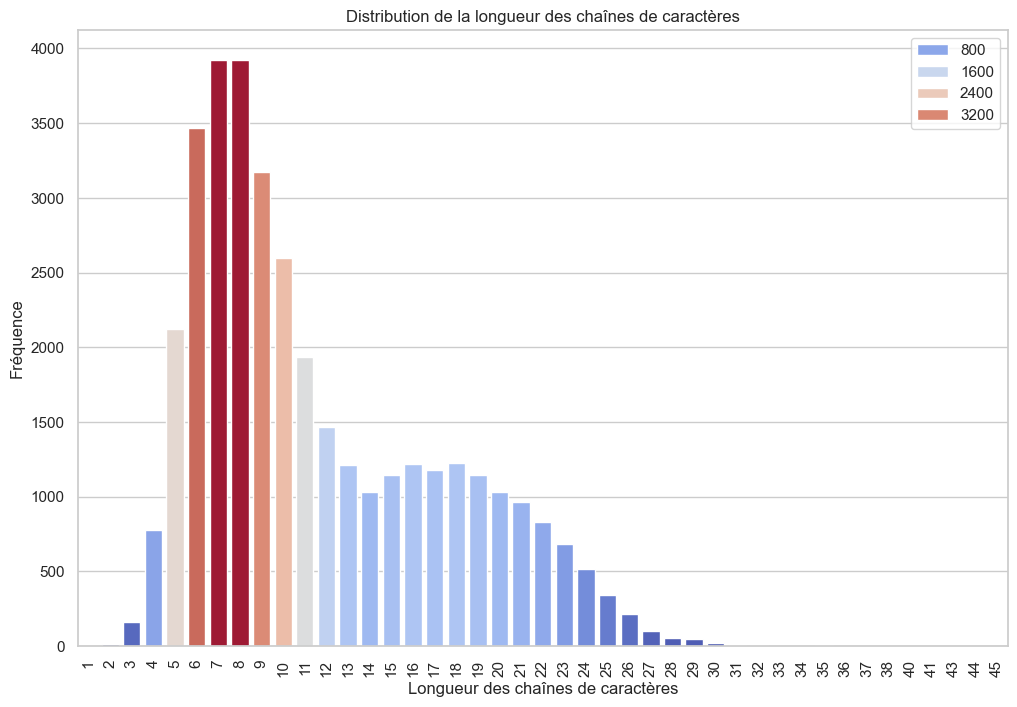

In [7]:
import seaborn as sns
# Configurer le thème de seaborn
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt

# Calculer la longueur des chaînes de caractères dans la colonne "nom"
df['length'] = df['nom'].apply(len)

# Afficher la distribution de la longueur des chaînes de caractères
length_distribution = df['length'].value_counts().sort_index()
#print(length_distribution)

# Afficher la distribution sous forme d'un histogramme
plt.figure(figsize=(12, 8))
sns.barplot(x=length_distribution.index, y=length_distribution.values, hue=length_distribution.values, palette="coolwarm")
plt.xlabel('Longueur des chaînes de caractères')
plt.ylabel('Fréquence')
plt.title('Distribution de la longueur des chaînes de caractères')
plt.xticks(rotation=90)
plt.show()

#### Fréquences des caractères

In [8]:
from collections import Counter

# Concaténer toutes les chaînes de caractères de la colonne "nom"
all_chars = ''.join(df['nom'])

# Compter les occurrences de chaque caractère
char_counts = Counter(all_chars)

# Convertir le résultat en dataframe pour une meilleure lisibilité
char_freq_df = pd.DataFrame(char_counts.items(), columns=['Caractère', 'Fréquence']).sort_values(by='Fréquence', ascending=False)

print("Nombre de caractères distincts :", len(char_freq_df))
display(char_freq_df)

Nombre de caractères distincts : 43


,Caractère,Fréquence
6,e,46107
0,a,37558
5,n,32035
10,l,30567
12,s,30264
1,r,30034
3,i,28939
17,-,26344
9,o,22464
7,u,21143


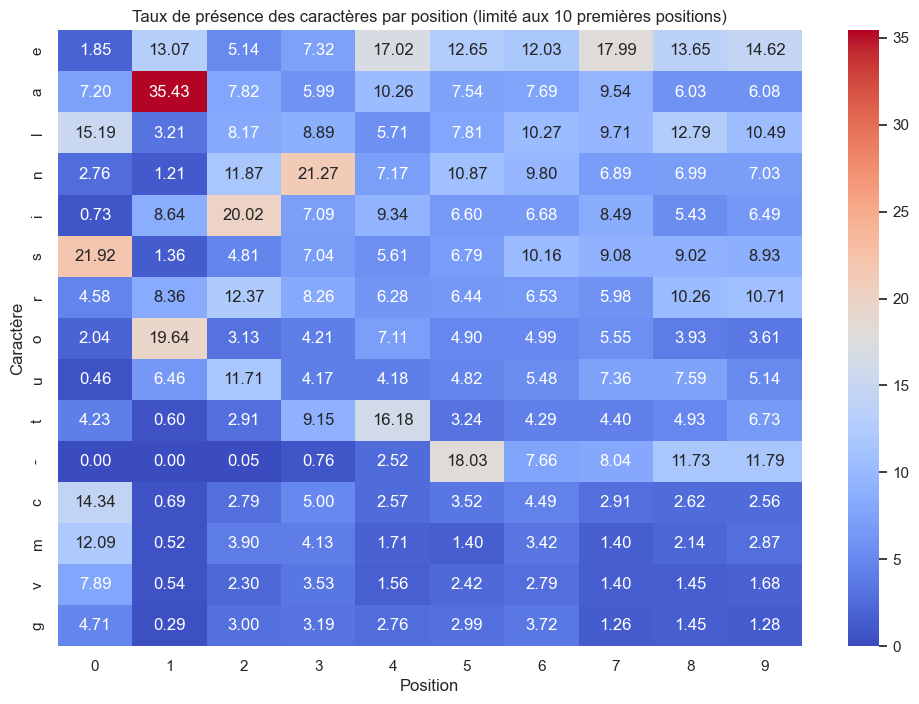

In [9]:
import numpy as np

# Limiter la longueur des noms à 10 caractères
df['nom_limited'] = df['nom'].str[:10]

# Initialiser un dictionnaire pour stocker les fréquences des caractères par position
position_char_freq = {i: Counter() for i in range(10)}

# Remplir le dictionnaire avec les fréquences des caractères par position
for name in df['nom_limited']:
    for i, char in enumerate(name):
        position_char_freq[i][char] += 1

# Convertir le dictionnaire en dataframe pour une meilleure lisibilité
position_char_freq_df = pd.DataFrame(position_char_freq).fillna(0).astype(int)

# Limiter aux 15 premiers caractères les plus fréquents
top_chars = position_char_freq_df.sum(axis=1).sort_values(ascending=False).head(15).index
position_char_freq_df = position_char_freq_df.loc[top_chars]

# Calculer le taux de présence par position
position_char_rate_df = position_char_freq_df.div(position_char_freq_df.sum(axis=0), axis=1) * 100

# Visualiser les taux de présence avec une carte de chaleur
plt.figure(figsize=(12, 8))
sns.heatmap(position_char_rate_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.xlabel('Position')
plt.ylabel('Caractère')
plt.title('Taux de présence des caractères par position (limité aux 10 premières positions)')
plt.show()

#### Fréquence des composants de nom

In [10]:
# Séparer les chaînes de caractères par "-" ou " " et les concaténer
element_separator = "-' "
all_elements = ' '.join(df['nom'].str.replace(f"[{element_separator}]", " ", regex=True).values).split()

# Compter les occurrences de chaque élément
element_counts = Counter(all_elements)

# Convertir le résultat en dataframe pour une meilleure lisibilité
element_freq_df = pd.DataFrame(element_counts.items(), columns=['Élément', 'Fréquence']).sort_values(by='Fréquence', ascending=False)

print(f"Nombre total de composants distincts : {len(element_freq_df)}")
display(element_freq_df.sample(15).sort_values(by='Fréquence', ascending=False))

# Filtrer les éléments dont la fréquence est supérieure à 1
element_freq_sup_1_df = element_freq_df[element_freq_df['Fréquence'] > 1]

# Afficher le nombre total d'éléments associés
print(f"Nombre total de composants présents plus d'une fois : {len(element_freq_sup_1_df)}")
display(element_freq_sup_1_df.head(15))


Nombre total de composants distincts : 28449


,Élément,Fréquence
7805,lametz,1
8134,herré,1
24524,véel,1
24581,caillère,1
2294,azif,1
21303,brimeux,1
14337,fervaches,1
11041,bachas,1
9969,jure,1
9301,dornas,1


Nombre total de composants présents plus d'une fois : 5807


,Élément,Fréquence
37,saint,4409
50,sur,2080
23,la,1868
30,le,1698
9,de,1229
101,en,971
96,lès,553
54,d,484
116,les,475
33,sainte,397


Combien de noms de communes sont composées ?
Quelle est la distribution du nombre de composants ?

,count
num_components,
1,21505
2,4776
3,6810
4,3243
5,210
6,33
7,5
8,1


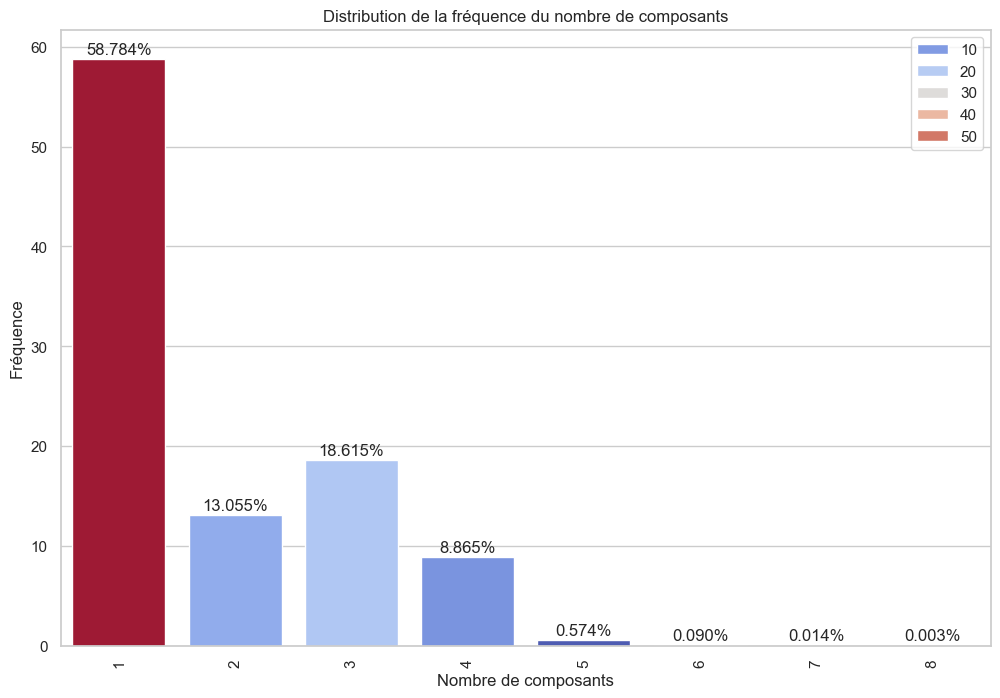

In [11]:
# Calculer le nombre de composants pour chaque nom
df['num_components'] = df['nom'].apply(lambda x: len([comp for comp in x if comp in element_separator]) + 1)

# Afficher la distribution du taux de fréquence du nombre de composants
component_distribution = df['num_components'].value_counts().sort_index()
component_distribution_rate = component_distribution / len(df) * 100
display(component_distribution.to_frame())

# Afficher la distribution sous forme d'un histogramme
plt.figure(figsize=(12, 8))
sns.barplot(x=component_distribution_rate.index, y=component_distribution_rate.values, hue=component_distribution_rate.values, palette="coolwarm")
for i in range(len(component_distribution_rate)):
    plt.text(i, component_distribution_rate.values[i] + 0.5, f'{component_distribution_rate.values[i]:.3f}%', ha='center')
plt.xlabel('Nombre de composants')
plt.ylabel('Fréquence')
plt.title('Distribution de la fréquence du nombre de composants')
plt.xticks(rotation=90)
plt.show()

## Le modèle

Explications et schémas

In [12]:
@dataclass
class TransformerConfig:
    d_model: int # D or d_model in comments
    n_layers: int
    n_heads: int
    max_len: int # maximum sequence length (for positional embedding)
    dropout: float = 0.1
    bias: bool = False
    norm_eps: float = 1e-5
    super_attn: bool = False # overwrites flash to False
    flash: bool = True

    def __post_init__(self):
        assert self.d_model % self.n_heads == 0, "d_model must be a multiple of n_heads"

        self.d_head = self.d_model // self.n_heads

In [13]:
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float):
        """
        Args :
            dim (int) : 
            eps (float) :
        """
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        
    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

In [14]:
class SelfAttentionMultiHead(nn.Module):
    def __init__(self, config: TransformerConfig):
        """
        Args :
            config (TransformerConfig) :
        """

        super().__init__()

        self.config = config

        # key, query, value projections for all heads
        self.query_proj = nn.Linear(config.d_model, config.d_model, bias=False) # d_query = n_heads*d_head as in the Transformer paper
        self.key_proj = nn.Linear(config.d_model, config.d_model, bias=False)
        self.value_proj = nn.Linear(config.d_model, config.d_model, bias=False)

        if not config.flash:
            # compute the mask once and for all here 
            # registrer treats it like a parameter (device, state_dict...) without training
            mask = torch.full((1, 1, config.max_len, config.max_len), float('-inf'))
            mask = torch.triu(mask, diagonal=1)
            self.register_buffer('mask', mask)

        # LxL super attention params
        if config.super_attn:
            self.k_in_v_proj = nn.Linear(in_features=config.max_len, out_features=config.max_len, bias=False)

        # output projection
        self.c_proj = nn.Linear(config.d_model, config.d_model, bias=config.bias)

        # regularization
        self.attn_drop = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

    def forward(self, X):
        # X : (B, T, d_model)

        B, L, _ = X.size()

        Q = self.query_proj(X).view(B, L, self.config.n_heads, self.config.d_head).transpose(1, 2) # (B, n_heads, L, d_query)
        K = self.key_proj(X).view(B, L, self.config.n_heads, self.config.d_head).transpose(1, 2) # (B, n_heads, L, d_key)
        V = self.value_proj(X).view(B, L, self.config.n_heads, self.config.d_head).transpose(1, 2) # (B, n_heads, L, d_head=d_value)

        if self.config.flash and not self.config.super_attn:
            attention = F.scaled_dot_product_attention(Q, K, V, attn_mask=None, dropout_p=self.config.dropout if self.training else 0, is_causal=True)
        else:
            QK_T = Q @ torch.transpose(K, 2, 3) # (B, n_heads, L, L)
            QK_T = QK_T + self.mask[:, :, :L, :L]

            attention_scores = torch.softmax(QK_T / math.sqrt(self.config.d_head), dim=3) # (B, n_heads, L, L)

            if self.config.super_attn:
                attention = self.attn_drop(attention_scores) @ self.k_in_v_proj.weight @ V # (B, n_h, L, d_value=d_head)
            else:
                attention = self.attn_drop(attention_scores) @ V # (B, n_h, L, d_value=d_head)

        attention = attention.transpose(1, 2) # (B, L, n_heafs, d_head)
        y = attention.contiguous().view(B, L, self.config.d_model) # n_heads * d_head = d_model

        y = self.resid_dropout(self.c_proj(y))

        return y

In [15]:
class MLP(nn.Module):
    def __init__(self, config: TransformerConfig):
        """
        Args :
            config (TransformerConfig) :
        """
        super().__init__()

        self.fc_1 = nn.Linear(config.d_model, 4 * config.d_model, bias=config.bias)
        self.fc_2 = nn.Linear(4 * config.d_model, config.d_model, bias=config.bias)
        self.fc_3 = nn.Linear(config.d_model, 4 * config.d_model, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        """
        """
        return self.dropout(self.fc_2(F.silu(self.fc_1(x)) * self.fc_3(x)))

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, config: TransformerConfig):
        """
        Args :
            config (TransformerConfig) :
        """
        super().__init__()

        self.config = config

        self.attention_norm = RMSNorm(config.d_model, config.norm_eps)
        self.sa = SelfAttentionMultiHead(config)
        self.mlp_norm = RMSNorm(config.d_model, config.norm_eps)
        self.mlp = MLP(config)

    def forward(self, X):
        """
        """
        # X : (B, L, D)

        # Y : (B, L, D)

        X = X + self.sa(self.attention_norm(X))
        X = X + self.mlp(self.mlp_norm(X))

        return X

In [17]:
class Transformer(nn.Module):
    def __init__(self, config: TransformerConfig):
        super().__init__()

        self.config = config

        self.PE = nn.Embedding(config.max_len, config.d_model)
        self.in_dropout = nn.Dropout(config.dropout)
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.n_layers)])

    def forward(self, X, stop_at_layer: int = None):
        """
        """
        # X : (B, L, D)
        # stop_at_layer (1 -> n_layers) : if set, will return the activations after the {layer}-th layer
        # Y : (B, L, D)

        _, T, _ = X.size()

        pos_emb = self.PE(torch.arange(0, T, dtype=torch.long, device=X.device))
        X = self.in_dropout(X + pos_emb)

        for i, layer in enumerate(self.layers):
            X = layer(X) # (B, L, d_model)

            if stop_at_layer == i+1:
                return X
        
        return X

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, model_config: TransformerConfig, vocab_size: int):
        super().__init__()

        self.config = model_config
        self.embedding = nn.Embedding(vocab_size, self.config.d_model, padding_idx=0)
        
        self.core = Transformer(self.config)
        self.out_norm = RMSNorm(self.config.d_model, self.config.norm_eps)
        self.lm_head = nn.Linear(self.config.d_model, vocab_size, bias=False)
        self.lm_head.weight = self.embedding.weight

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('fc_3.weight') or  pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * self.config.n_layers))
    
    def forward(self, tokens, act = False):
        # tokens : (B, L)

        # logits : (B, L, vocab_size)

        x = self.embedding(tokens)
        x = self.core(x)

        if act:
            return x
        
        x = self.out_norm(x)
        logits = self.lm_head(x)

        return logits

    def generate(self, prompt, num_tokens, sample):
        # prompt : (1, len)

        self.eval()

        generated = prompt.clone()

        with torch.no_grad():
            for _ in range(num_tokens):
                logits = self.forward(generated) # (B, L, vocab_size)
                next_token_logits = logits[:, -1]

                if sample:
                    probs = F.softmax(next_token_logits, dim=-1)
                    next_token = torch.multinomial(probs, num_samples=1)
                else:
                    next_token = next_token_logits.argmax(dim=-1, keepdim=True)
                generated = torch.cat([generated, next_token], dim=1)
        
        return generated
    
    def forward_up_to(self, tokens, layer):
        # tokens : (B, L)
        # layer (1->n_layers): will stop the forward pass just after this layer

        # x : (B, L, D) activations after {layer}

        x = self.embedding(tokens)
        x = self.core(x, stop_at_layer=layer)

        return x
    
    # taken from llama2.c
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    

## Dataset et Dataloader

In [19]:
PAD = "<pad>" # Padding
SOS = "<SOS>" # Start Of Sequence
EOS = "<EOS>" # End Of Sequence

class Dataset():
    def __init__(self, file_name: str = "villes.txt", device="cpu"):

        # chargement des données
        fichier = open(file_name)
        donnees = fichier.read()
        villes = donnees.replace('\n', ',').split(',')
        # mise à l'écart des villes avec un nom de longueur inférieure à 3
        self.villes = [ville for ville in villes if len(ville) > 2]

        # création du vocabulaire
        self.vocabulaire = sorted(list(set(''.join(villes))))
        self.vocabulaire = [PAD, SOS, EOS] + self.vocabulaire
        # <SOS> et <EOS> sont ajoutés respectivement au début et à la fin de chaque séquence
        # <pad> est utilisé pour faire en sorte que toutes les séquences aient la même longueur

        # pour convertir char <-> int
        self.char_to_int = {}
        self.int_to_char = {}

        for (c, i) in tqdm(zip(self.vocabulaire, range(len(self.vocabulaire))), desc="creating vocabulary", total=len(self.vocabulaire)):
            self.char_to_int[c] = i
            self.int_to_char[i] = c

        num_sequences = len(villes)
        self.max_len = max([len(ville) for ville in villes]) + 2 # <SOS> et <EOS>

        X = torch.zeros((num_sequences, self.max_len), dtype=torch.int32, device=device)

        for i in trange(num_sequences, desc="creatind dataset"):
            X[i] = torch.tensor([self.char_to_int[SOS]] +
                                [self.char_to_int[c] for c in villes[i]] +
                                [self.char_to_int[EOS]] +
                                [self.char_to_int[PAD]] * (self.max_len - len(villes[i]) - 2))

        n_split = int(0.9 * X.shape[0])

        idx_permut = torch.randperm(X.shape[0])
        idx_train, _ = torch.sort(idx_permut[:n_split])
        idx_val, _ = torch.sort(idx_permut[n_split:])

        self.X_train = X[idx_train]
        self.X_val = X[idx_val]

    def get_batch(self, batch_size: int, split : str="val", device=None) -> torch.Tensor:
        assert split in ["train", "val"], f"split ({split}) should be 'train' or 'val'." 

        data = self.X_train if split == 'train' else self.X_val

        idx = torch.randint(low=int(batch_size/2), high=int(data.shape[0]-batch_size/2), size=(1,), dtype=torch.int32).item()

        batch = data[int(idx-batch_size/2):int(idx+batch_size/2)]
        X = batch[:, :-1] # (B, L=max_len-1=46)
        Y = batch[:, 1:] # (B, L)
        if device:
            X = X.to(device)
            Y = Y.to(device)
        return X, Y.long()
    
    def cast_char_to_int(self, sequence: list[str]) -> list[int]:
        return [self.char_to_int[c] for c in sequence]
    
    def cast_int_to_char(self, sequence: list[int]) -> list[str]:
        return [self.int_to_char[i] for i in sequence]

In [20]:
dataset = Dataset(device=device) # toute la partie données de 2_mlp.py a été encapsulée dans l'objet Dataset

creating vocabulary:   0%|          | 0/46 [00:00<?, ?it/s]

creatind dataset:   0%|          | 0/36585 [00:00<?, ?it/s]

Test du dataset

In [21]:
X, Y = batch = dataset.get_batch(batch_size=2)
print("> X (ids):", X.to("cpu"), sep="\n")
print("> caractères correspondants pour la première séquence :", dataset.cast_int_to_char(X[0].to("cpu").tolist()), sep="\n")

> X (ids):
tensor([[ 1, 11, 23,  6, 19,  8,  6, 31,  6, 17,  2,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 24,  6, 14, 19, 25,  5, 18,  6, 18, 10, 25,  5, 17,  6,  5, 24,  6,
         17, 27, 10, 25,  6, 25,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=torch.int32)
> caractères correspondants pour la première séquence :
['<SOS>', 'f', 'r', 'a', 'n', 'c', 'a', 'z', 'a', 'l', '<EOS>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


## Entrainement

In [22]:
d_model = 32 # dimension du modèle
n_heads = 4 # nombre de têtes pour l'attention
n_layers = 1 # nombre de couches
dropout = 0.

lr = 3e-4
batch_size = 64

iterations = 10000
print_each = 1000

In [23]:
config = TransformerConfig(d_model=d_model, n_heads=n_heads, n_layers=n_layers, dropout=dropout, max_len=dataset.max_len)
model = LanguageModel(config, vocab_size=len(dataset.vocabulaire)).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=lr)

print(model)
print(f"Nombre de paramètres : {sum(p.numel() for p in model.parameters())}")

LanguageModel(
  (embedding): Embedding(46, 32, padding_idx=0)
  (core): Transformer(
    (PE): Embedding(47, 32)
    (in_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): DecoderLayer(
        (attention_norm): RMSNorm()
        (sa): SelfAttentionMultiHead(
          (query_proj): Linear(in_features=32, out_features=32, bias=False)
          (key_proj): Linear(in_features=32, out_features=32, bias=False)
          (value_proj): Linear(in_features=32, out_features=32, bias=False)
          (c_proj): Linear(in_features=32, out_features=32, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp_norm): RMSNorm()
        (mlp): MLP(
          (fc_1): Linear(in_features=32, out_features=128, bias=False)
          (fc_2): Linear(in_features=128, out_features=32, bias=False)
          (fc_3): Linear(in_features=32, out_features=128, bias=False)
          (dropout): Dropout(p=0

In [24]:
model.train()
for i in trange(iterations):
    X, Y = dataset.get_batch(split='train', batch_size=batch_size) # (B, L)
    logits = model(X) # (B, L, vocab_size)

    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=dataset.char_to_int[PAD])
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i%print_each==0:
        model.eval()
        X, Y = dataset.get_batch(batch_size=batch_size) # (B, L)
        logits = model(X) # (B, L, vocab_size)
        val_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=dataset.char_to_int[PAD]).item()

        print(f"\tperte entrainement (itération #{i:5d}): {loss.item():.2f} | perte de validation : {val_loss:.2f}")
        model.train()

model.eval();

  0%|          | 0/10000 [00:00<?, ?it/s]

	perte entrainement (itération #    0): 3.85 | perte de validation : 3.83
	perte entrainement (itération # 1000): 2.26 | perte de validation : 2.17
	perte entrainement (itération # 2000): 2.08 | perte de validation : 2.18
	perte entrainement (itération # 3000): 1.97 | perte de validation : 1.97
	perte entrainement (itération # 4000): 1.97 | perte de validation : 1.97
	perte entrainement (itération # 5000): 2.04 | perte de validation : 1.90
	perte entrainement (itération # 6000): 1.87 | perte de validation : 1.83
	perte entrainement (itération # 7000): 1.82 | perte de validation : 1.86
	perte entrainement (itération # 8000): 1.77 | perte de validation : 1.86
	perte entrainement (itération # 9000): 1.83 | perte de validation : 1.92


In [25]:
X = dataset.X_train[:, :-1].to(device) # (B, L=max_len-1=46)
Y = dataset.X_train[:, 1:].long().to(device) # (B, L)

logits = model(X) # (B, L, vocab_size)
loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=dataset.char_to_int['<pad>'])
print(f"total train loss : {loss.item():.2f}")

X = dataset.X_val[:, :-1].to(device) # (B, L=max_len-1=46)
Y = dataset.X_val[:, 1:].long().to(device) # (B, L)

logits = model(X) # (B, L, vocab_size)
loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=dataset.char_to_int['<pad>'])
print(f"total val loss   : {loss.item():.2f}")

total train loss : 1.80
total val loss   : 1.82


In [26]:
timestamp = datetime.datetime.now().strftime("%Y%M%d-%I%M%S")
torch.save(model.state_dict(), f"model_{d_model}__{n_heads}_heads__{n_layers}_layers__{timestamp}.pth")

## Génération de noms de commune

In [27]:
def sample(model, prompt = "", device="cpu", g = torch.Generator(device)):
    idx = torch.tensor([dataset.char_to_int[c] for c in prompt], dtype=torch.int32, device=device).unsqueeze(0)
    idx = torch.cat([torch.tensor(dataset.char_to_int[SOS], device=device).view(1, 1), idx], dim=1)
    next_id = -1

    while next_id != dataset.char_to_int[EOS]:
        logits = model(idx) # (1, l, d_model)

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_id = torch.multinomial(probs, num_samples=1, generator=g).item()
        idx = torch.cat([idx, torch.tensor(next_id, device=device).view(1, 1)], dim=1)

        if idx.shape[1] > config.max_len:
            break
        
    return "".join([dataset.int_to_char[p.item()] for p in idx[0, 1:-1]])

In [28]:
for _ in range(15):
    print(sample(model, prompt="la", device=device, g=pth_rnd_gen))

labachac
langlais
larcy
la mix-de-sur-jeaux
la vauxieis
la czaps
laxelles
la cheau-de-sur-etonjon
la chépellontme-boir
la chapat
labre
la bagnige
la sainte-c
la cheuvière
la côre-ez


## Interprétabilité

### Visualisation des matrice d'attention

### Recherche des concepts avec l'utilisation d'un SAE

#### Création et entrainement d'un SAE

Présentation des concepts

In [29]:
class AutoEncoder(nn.Module):
    def __init__(self, act_size, num_features, l1_coeff):
        super().__init__()

        self.l1_coeff = l1_coeff
        self.num_features = num_features

        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(act_size, num_features)))
        self.b_enc = nn.Parameter(torch.zeros(num_features))

        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(num_features, act_size)))
        self.b_dec = nn.Parameter(torch.zeros(act_size))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
    
    def encode(self, x):
        x_cent = x - self.b_dec
        return F.relu(x_cent @ self.W_enc + self.b_enc) # calcul des activations des concepts
    
    def decode(self, x):
        return x @ self.W_dec + self.b_dec # calcul de la reconstruction

    def reconstruct_loss(self, x, acts, x_reconstruct):
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0) # loss de reconstruction
        l1_loss = self.l1_coeff * (acts.float().abs().sum()) # penalité L1 sur les activations des concepts
        return l1_loss, l2_loss
    
    def forward(self, x):
        x_cent = x - self.b_dec
        acts = self.encode(x)
        x_reconstruct = self.decode(acts)

        l1_loss, l2_loss = self.reconstruct_loss(x, acts, x_reconstruct)
        loss = l2_loss + l1_loss # loss total

        return loss, x_reconstruct, acts, l2_loss, l1_loss
    
    # permet de stabiliser l'entraînement
    @torch.no_grad()
    def make_decoder_weights_and_grad_unit_norm(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj
        # Bugfix(?) for ensuring W_dec retains unit norm, this was not there when I trained my original autoencoders.
        self.W_dec.data = W_dec_normed

chargement du modèle si besoin, sans passer par la phase d'apprentissage du modèle

In [30]:
def load_model(filename: str, device="cpu", verbose: bool =True):
    model = LanguageModel(config, vocab_size=len(dataset.vocabulaire))
    model.load_state_dict(torch.load(filename, map_location=torch.device('cpu')))
    if verbose:
        print(model)
    return model.to(device)

In [31]:
do_load_model = False
if do_load_model:
    model_weights = "model32_n_heads4_n_layers1_20250025-030058.pth"
    model = load_model(model_weights, device=device)
model.eval();

In [32]:
act_size = config.d_model
num_features = 4 * config.d_model
sae = AutoEncoder(act_size=act_size, num_features=num_features, l1_coeff=3e-4)
optim = torch.optim.Adam(sae.parameters(), lr=3e-4)

In [33]:
iterations = 1000
batch_size = 16
print_every = 100

sae.to(device)
sae.train()
for i in trange(iterations, desc="apprentissage"):
    # on récupère les données
    X, Y = dataset.get_batch(split='train', batch_size=batch_size) # (B, L)

    # on les fait passer dans le modèle et on récupère les activations du modèle (avec act=True, on "sort" du modèle avant la sortie)
    act = model(X, act=True).view(-1, config.d_model) # (B*L, 128)

    loss, x_reconstruct, features, l2_loss, l1_loss = sae(act)
    loss.backward()
    sae.make_decoder_weights_and_grad_unit_norm()
    optim.step()
    optim.zero_grad()
    
    if i % print_every == 0:
        print(f"loss : {loss.item()}")

apprentissage:   0%|          | 0/1000 [00:00<?, ?it/s]

loss : 5.893471717834473
loss : 1.9906123876571655
loss : 1.3026940822601318
loss : 1.0804719924926758
loss : 0.9066196084022522
loss : 0.7246869802474976
loss : 0.7728164196014404
loss : 0.6795124411582947
loss : 0.6427016258239746
loss : 0.6344951391220093


Explications concernant les fréquences des caractéristiques

In [34]:
# frequence des features
X, Y = dataset.get_batch(split='val', batch_size=512) # (B, L)
act = model(X, act=True).view(-1, config.d_model)
_, _, features, _, _ = sae(act)

rate = ((((features > 0).int()).sum(0) / features.shape[0]) < 1e-1).float().mean()
print(f"fraction des caractéristiques avec une fréquence < 1/10 : {rate}")

rate = ((((features > 0).int()).sum(0) / features.shape[0]) < 1e-2).float().mean()
print(f"fraction des caractéristiques avec une fréquence < 1/100 : {rate}")

rate = ((((features > 0).int()).sum(0) / features.shape[0]) < 1e-3).float().mean()
print(f"fraction des caractéristiques avec une fréquence < 1/1.000 : {rate}")

rate = ((((features > 0).int()).sum(0) / features.shape[0]) < 1e-4).float().mean()
print(f"fraction des caractéristiques avec une fréquence < 1/10.000 : {rate}")

fraction des caractéristiques avec une fréquence < 1/10 : 0.6484375
fraction des caractéristiques avec une fréquence < 1/100 : 0.046875
fraction des caractéristiques avec une fréquence < 1/1.000 : 0.0
fraction des caractéristiques avec une fréquence < 1/10.000 : 0.0


In [35]:
torch.save(sae.state_dict(), f"sae_model_{d_model}__{n_heads}_heads__{n_layers}_layers__{timestamp}.pth")

#### Visualisations

In [36]:
X, Y = dataset.get_batch(split='train', batch_size=1) # (B, L)
act = model(X, act=True).view(-1, config.d_model) # (B, L, d_model)
_, act_recon, features, _, _ = sae(act)

##### visualisation des activations des features

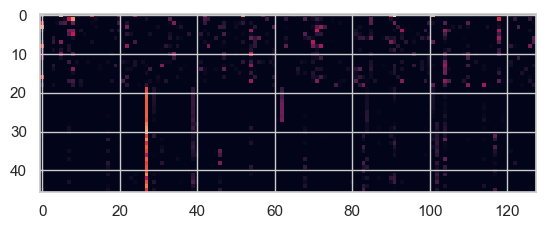

In [37]:
plt.imshow(features.to("cpu").detach())
plt.show()

##### visualisation des activations

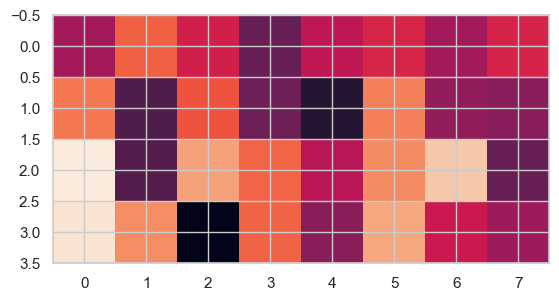

In [38]:
plt.imshow(act[40].view(4, 8).to("cpu").detach())
plt.show()
#plt.savefig('act_40', dpi=200)

##### visualisation des activations des features

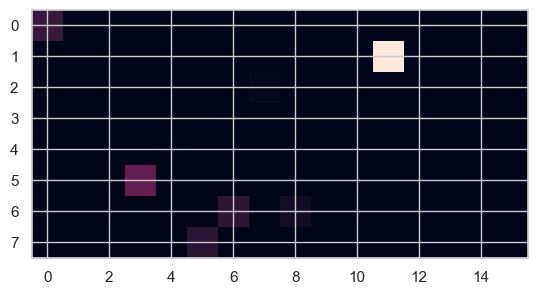

In [39]:
plt.imshow(features[40].view(8, 16).to("cpu").detach())
plt.show()
#plt.savefig('features_40', dpi=600)

##### visualisation des activations et de leurs reconstructions :

Visualisation des activations.

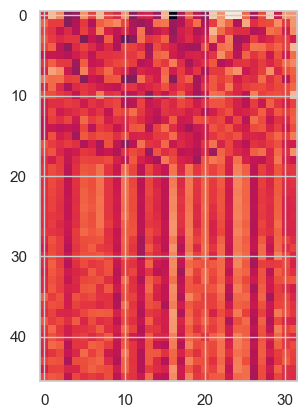

In [40]:
plt.imshow(act.to("cpu").detach())
plt.show()

Visualisation de leur reconstruction.

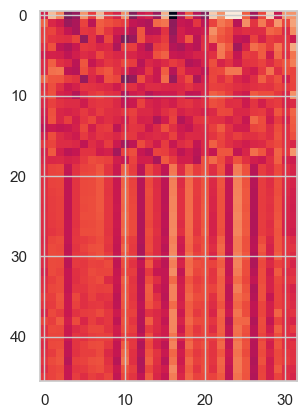

In [41]:
plt.imshow(act_recon.to("cpu").detach())
plt.show()

Calcul de la perte en cas d'utilisation des reconstructions à la place des activations initiales.

In [42]:
X, Y = dataset.get_batch(split="val", batch_size=64) # (B, L)
act = model(X, act=True).view(-1, config.d_model)
_, act_recon, features, _, _ = sae(act)

x = model.out_norm(act_recon)
logits = model.lm_head(x)

loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=dataset.char_to_int[PAD])
print(f"reconstruction loss : {loss.item():.2f}")

reconstruction loss : 2.10


#### Exploration des neurones et concepts

In [43]:
def do_load_sae(filename: str, act_size: int, num_features: int, device="cpu") -> torch.Tensor:
    sae = AutoEncoder(act_size=act_size, num_features=num_features, l1_coeff=3e-4)
    sae.load_state_dict(torch.load(filename))
    return sae.to(device)

In [44]:
do_load_model = False
if do_load_model:
    model_weights = "model32_n_heads4_n_layers1_20250025-030058.pth"
    model = load_model(model_weights, device=device)
model.eval();

In [45]:
load_sae = False
if load_sae:
    act_size = config.d_model
    num_features = 4 * config.d_model
    sae = do_load_sae("sae_model_32__4_heads__1_layers__20252925-032910.pth", 
                      act_size=act_size, num_features=num_features, device=device)

##### neurones interprétables ?

Garde les 20 valeurs (et leur indice) les plus grandes parmi top_values et new_values.

les appels successifs de cette fonction vont permettre de déterminer par paquets/batchs les valeurs (et leur indice) les plus grandes parmi une liste de valeurs (cf l'utilisation en dessous).

In [46]:
def update_top_k(top_values, top_indices, new_values, new_indices, k=20):
    combined_values = torch.cat([top_values, new_values])
    combined_indices = torch.cat([top_indices, new_indices])
    
    new_top_values, topk_indices = torch.topk(combined_values, k)
    new_top_indices = combined_indices[topk_indices]
    
    return new_top_values, new_top_indices

In [47]:
top_k = 20 # on garde les 20 exemples qui font s'activer chaque neurone le plus
batch_size = 64 # on travaille par paquets de 64

On commence avec des valeurs minimales (-inf) et des indices arbitraires (-1).

- `top_values`, de taille (n_neurones, top_k), répertorie les 20 valeurs d'activations max de chaque neurone
- `top_indices`, de taille (n_neurones, top_k), répertorie les indices qui correspondent à ces valeurs (indices=indice dans le dataset=indice d'une commune)

pour chaque paquet/batch :<br>
   - on fait passer le batch dans le réseau<br>
   - on récupère les activations (B, L, n_neurones) = n_neurones activations (1 par neurone) pour chaque lettre (L) pour chaque commune (B)<br>
   - on prend en compte l'activation maximale (selon la position)<br>

pour chaque neurone :<br>
   - on utilise la fonction update_top_k pour mettre à jour top_values et top_indices


In [48]:
top_values = torch.full((config.d_model, top_k), -float('inf'))
top_indices = torch.full((config.d_model, top_k), -1, dtype=torch.long)

for i in trange(0, dataset.X_train.shape[0], batch_size):
    X = dataset.X_train[i:i+batch_size]
    act = model(X, act=True) # (B, L, n_neurones)
    act = act.to("cpu")
    max_act = act.max(dim=1).values # (B, n_neurones)

    for dim in range(config.d_model):
        dim_values = max_act[:, dim]
        dim_indices = i + torch.arange(batch_size)

        top_values[dim], top_indices[dim] = update_top_k(top_values[dim], top_indices[dim], dim_values, dim_indices)

  0%|          | 0/515 [00:00<?, ?it/s]

In [49]:
idx_neurone = 5
for i in top_indices[idx_neurone]:
    ville = "".join([dataset.int_to_char[k] for k in [p.item() for p in dataset.X_train[i.item()] if p.item() != 0] if k != 1 and k != 2])
    act = model(dataset.X_train[i.item()].unsqueeze(0), act=True) # (B, L, n_neurones)

    print_colore(ville, act[0, :, idx_neurone].tolist()[:len(ville)])

##### caractéristiques interprétables ?

Le principe est exactement le même qu'avec les neurones, mais on regarde les features/concepts


In [50]:
top_k = 20
batch_size = 64

In [51]:
top_values = torch.full((sae.num_features, top_k), -float('inf'))
top_indices = torch.full((sae.num_features, top_k), -1, dtype=torch.long)

for i in trange(0, dataset.X_train.shape[0], batch_size):
    X = dataset.X_train[i:i+batch_size]
    act = model(X, act=True) # (B, L, 128)
    _, _, features, _, _ = sae(act)
    max_features = features.max(dim=1).values # (B, 128)
    max_features = max_features.to("cpu")
    
    for dim in range(sae.num_features):
        dim_values = max_features[:, dim]
        dim_indices = i + torch.arange(batch_size)

        top_values[dim], top_indices[dim] = update_top_k(top_values[dim], top_indices[dim], dim_values, dim_indices)

  0%|          | 0/515 [00:00<?, ?it/s]

In [52]:
idx_feature = 4
for i in top_indices[idx_feature]:
    ville = "".join([dataset.int_to_char[k] for k in [p.item() for p in dataset.X_train[i.item()] if p.item() != 0] if k != 1 and k != 2])
    act = model(dataset.X_train[i.item()].unsqueeze(0), act=True) # (B, L, 128)
    _, _, features, _, _ = sae(act)

    print_colore(ville, features[0, :, idx_feature].tolist()[:len(ville)])

### Modifier le comportement en le dirigeant

explications et descriptions

In [53]:
def steered_sample(model, sae, prompt = "", g = torch.Generator(), steering_vector=None, device="cpu"):
    """
    """
    idx = torch.tensor([dataset.char_to_int[c] for c in prompt], dtype=torch.int32, device=device).unsqueeze(0)
    idx = torch.cat([torch.tensor(dataset.char_to_int[SOS], device=device).view(1, 1), idx], dim=1)
    next_id = -1

    while next_id != dataset.char_to_int[EOS]:
        act = model(idx, act=True) # (1, l, d_model)

        # SAE
        features = sae.encode(act) # (1, l, num_features)
        act_reconstruct_1 = sae.decode(features) # (1, l, d_model) # reconstruction sans modification

        features[:, :, steering_vector[0].long()] = steering_vector[1].float() # forçage des concepts sur toutes les lettres
        act_reconstruct_2 = sae.decode(features) # reconstruction avec modification

        error = act - act_reconstruct_1
        final_act = act_reconstruct_2 + error

        x = model.out_norm(final_act)
        logits = model.lm_head(x)

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_id = torch.multinomial(probs, num_samples=1, generator=g).item()
        idx = torch.cat([idx, torch.tensor(next_id, device=device).view(1, 1)], dim=1)

        if idx.shape[1] > config.max_len:
            break
        
    return "".join([dataset.int_to_char[p.item()] for p in idx[0, 1:-1]])

In [58]:
steering_vector = torch.tensor([[4, -1]], dtype=int, device=device)

for i in range(15):
    print(steered_sample(model, sae, steering_vector=steering_vector.mT, prompt="x", device=device, g=pth_rnd_gen))

xétrones-haûzeux-arnqodrén
xoupsshop-ghémont
xuslœz-soussés<pad><pad><pad><pad><pad>ÿÿÿ<pad><pad><pad><pad><pad>œ<pad><pad><pad>üqux
xanque-llaz
xazelles-bouthos
xernzéan-llôme-dâté
xujulquezz-la-p-mosnïtadme
xézon
xenhîné-aguxsçûléze
xÿbeucque
xëlhalo<pad>üleïnquoun
xoblenhed
xôlehhupoussha-suzondes
xhoudy-suzéson
xoquanèséœûlex-polquesn


In [59]:
steering_vector = torch.tensor([[4, 1]], dtype=int, device=device)

for i in range(15):
    print(steered_sample(model, sae, steering_vector=steering_vector.mT, prompt="x", device=device, g=pth_rnd_gen))

xiivier
xibrieux
xelleimoirieià-duille-bievise
xeypierviey
xairessiais
xicinacolbert
xaviailiry
xefeviville-ilivierrjie
xibieross
xuvilcoile
xagnisc
ximorivilier
xoaigny
xinisilies-surivile
xavilsay
